In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
from optic.models.devices import photodiode, basicLaserModel
from optic.models.channels import linearFiberChannel
from optic.dsp.core import phaseNoise, firFilter, pulseShape, signal_power ,delaySignal
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from scipy.constants import h, c
import scipy.signal as signal
from scipy.signal import hilbert
from scipy.signal.windows import hamming
from scipy.ndimage import shift
from IPython.display import display, Math
from commpy.utilities import upsample
from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

sys.path.append('..\..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# Parameters and simulation

In [42]:
# simulation parameters
SpS = 64    # Samples per Symbol
Rs = 330e6  # Symbol rate (for OOK case Rs = Rb)

Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**14)
n = np.arange(0, bitsTx.size)

lmbd = 1540e-9 # Wavelength [m]
KConst = 0.5         # Coupling Constant (0 to 1)
KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

SMFLen = 12          # Single Mode Fiber Length (km)
SMFAtt = 0.22        # Single Mode Fiber Attenuation (dB/km)
SMFGamma = 1.2       # Single Mode Fiber Nonlinear parameter (1/(W*km))
SMFDisp = 16         # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)
tau = SMFLen/(c*1e-3)    # Fiber Delay

bIdx = 2.63           # Modulation index of the electrical modulating signal
mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
mPhase = 0      # Phase of the electrical modulating signal (Radians)
R = 1           # Photodiode Responsivity

tArray = np.arange(0,SpS*len(bitsTx))*Ts

laser_parameters = parameters()
laser_parameters.P = 10 # laser power [dBm] 
laser_parameters.lw = 1e6 # laser linewidth [Hz] 
laser_parameters.RIN_var = 1e-20 # variance of the RIN noise 
laser_parameters.Fs = Fs # sampling rate [samples/s]
laser_parameters.Ns = SpS*bitsTx.size # number of signal samples

OptSig = basicLaserModel(laser_parameters)

print(f'Samples: {SpS*bitsTx.size}')
print(f'Total sample time: {SpS*len(bitsTx)*Ts*1e6} us')
print(f'Sampling period: {Ts*1e12} ps')
print(f'Sampling frequency: {Fs*1e-9} Gsample/s')
print(f'Linewidth: {laser_parameters.lw * 1e-3} kHz')

Samples: 1048576
Total sample time: 49.64848484848485 us
Sampling period: 47.34848484848485 ps
Sampling frequency: 21.12 Gsample/s
Linewidth: 1000.0 kHz


Text(0.5, 1.0, 'DFB laser spectrum')

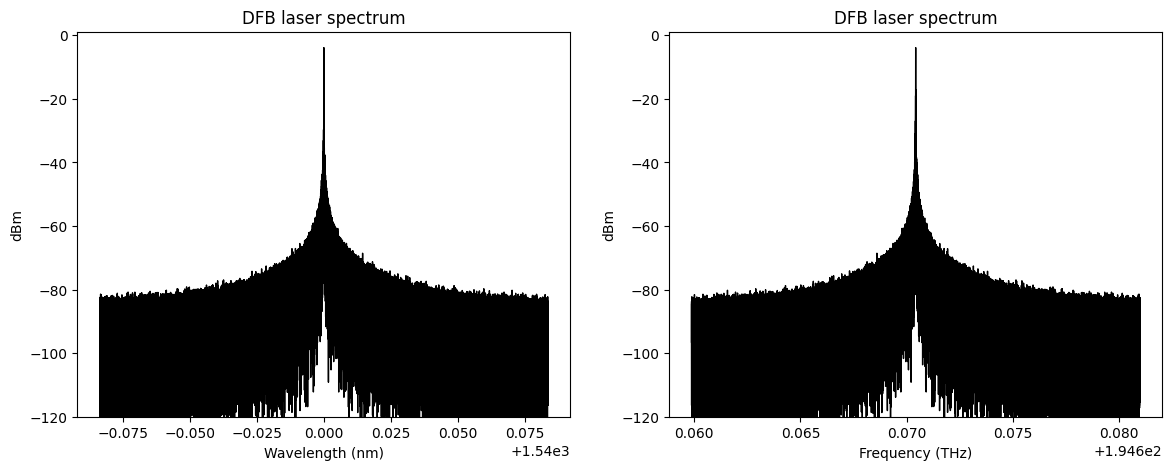

In [43]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(14)

freq, spectrum = get_spectrum(OptSig, Fs=Fs, Fc=c/lmbd)
ax[0].plot(freq*1e9, spectrum, color='black',linewidth = 1)
# ax[0].set_xlim(1.538,1.542)
ax[0].set_ylim(-120,np.max(spectrum)+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_title('DFB laser spectrum')

freq, spectrum = get_spectrum(OptSig, Fs=Fs, Fc=c/lmbd, xunits='hz')
ax[1].plot(freq*1e-12, spectrum, color='black',linewidth = 1)
# ax[1].set_xlim(c/1.538*1e-6,c/1.542*1e-6)
ax[1].set_ylim(-120,np.max(spectrum)+5)
ax[1].set_ylabel('dBm')
ax[1].set_xlabel('Frequency (THz)')
ax[1].set_title('DFB laser spectrum')

# Self-Heterodyne Circuit Operations

In [50]:
LinearFiber_parameters = parameters()
LinearFiber_parameters.L = SMFLen           # [km] total fiber length
LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
LinearFiber_parameters.Fc = c/lmbd  # [Hz] carrier frequency
LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

TIACutFreq = 4e9  # TIA Filter cuttoff frequency in Hz   
TIAorder = 4  # TIA Filter order      

DemodCutFreq = 0.1e9  # Demodulation Filter cuttoff frequency in Hz     
Demodorder = 3  # Demodulation Filter order

tau = SMFLen/(c*1e-3)    # Fiber Delay
shiftValue = int(len(tArray)*tau/tArray[-1])
print(f'Delay: {tau*1e6} us')

EUpper = linearFiberChannel(OptSig*np.sqrt(KConst),LinearFiber_parameters)  
EUpper = shift(EUpper,shiftValue,cval=EUpper[0])
EUpper = EUpper[shiftValue:]

carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
EBottom = carrier*np.exp(1j*bIdx*np.sin(2*np.pi*mFreq*tArray+mPhase))
EBottom = EBottom[shiftValue:]

timeArray = tArray[shiftValue:]

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode


# TIA Filter ---------------------------------------------------------

w_norm = TIACutFreq / (Fs/2)
b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredIPd = signal.lfilter(b, a, IPd)

Q_Sig = FilteredIPd*np.sin(2*np.pi*mFreq*timeArray+mPhase)
I_Sig = -FilteredIPd*np.cos(2*(2*np.pi*mFreq*timeArray+mPhase))

# Demodulation Filtering ----------------------------------------------      

w_norm = DemodCutFreq / (Fs/2)
b,a = signal.bessel(N=Demodorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredQ_Sig = signal.lfilter(b, a, Q_Sig)
FilteredI_Sig = signal.lfilter(b, a, I_Sig)

# Complex Signal Construction ------------------------------------------ 

CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
instFreq = (np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)) / (2*np.pi*Ts) # Instantaneous frequency

Delay: 40.02769142377824 us


# Phase-Noise Characterization

## E-Field PSD

leftMark between 1999.01 and 1999.11 MHz
rightMark between 2000.98 and 2001.08 MHz


<IPython.core.display.Math object>

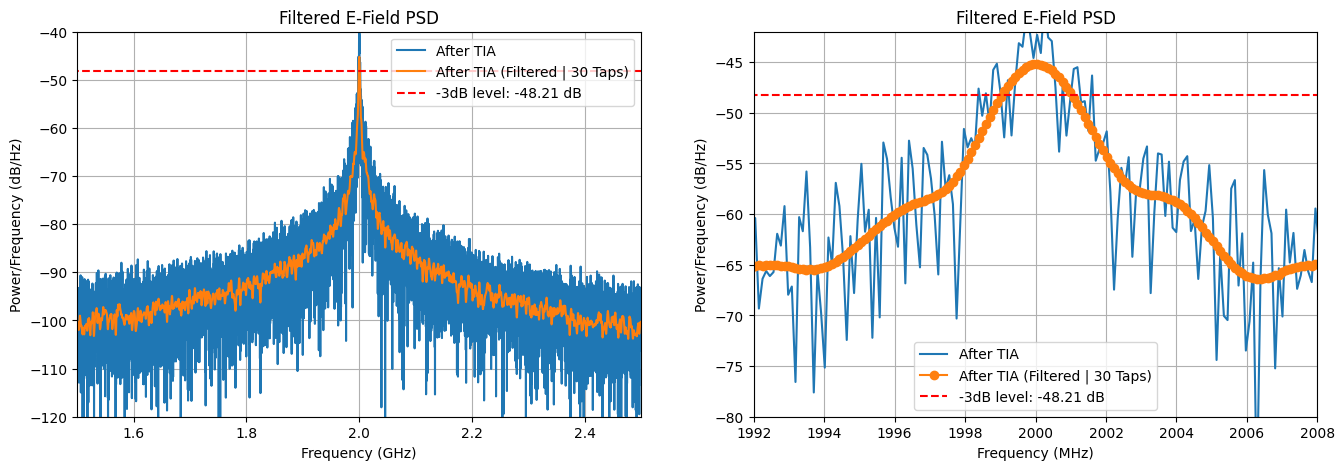

In [55]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(16)

cutLims = [1.45e9,2.55e9]
freq, spectrum = get_spectrum(FilteredIPd, Fs=Fs, Fc=0, xunits='hz',sides='onesided')

initFreq = int(cutLims[0]/freq[-1]*len(freq))
endFreq = int(cutLims[1]/freq[-1]*len(freq))

freq = freq[initFreq:endFreq]
spectrum = spectrum[initFreq:endFreq]

# Filter spectrum
Ntaps = 30
b = signal.firwin(numtaps = Ntaps, cutoff = 0.01, window='hamming')
FilteredSpec = firFilter(b, spectrum)  

ax[0].plot(freq*1e-9,spectrum, label='After TIA')
ax[0].plot(freq*1e-9,FilteredSpec, label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(-120,-40)
ax[0].set_title(f'Filtered E-Field PSD')
ax[0].grid()
ax[0].legend(fontsize=10)

ax[1].plot(freq*1e-6,spectrum, label='After TIA')
ax[1].plot(freq*1e-6,FilteredSpec,'-o', label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(2000 - 8 , 2000 + 8)
ax[1].set_ylim(-80,-42)
ax[1].set_title(f'Filtered E-Field PSD')
ax[1].grid()
ax[1].legend(fontsize=10)

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
        print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
    elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(rightMark*1e-6-leftMark*1e-6 , (rightMark*1e-6-leftMark*1e-6)/2 )))

## Frequency Modulation Noise Spectrum

Fs = 21.12 GSamples/s


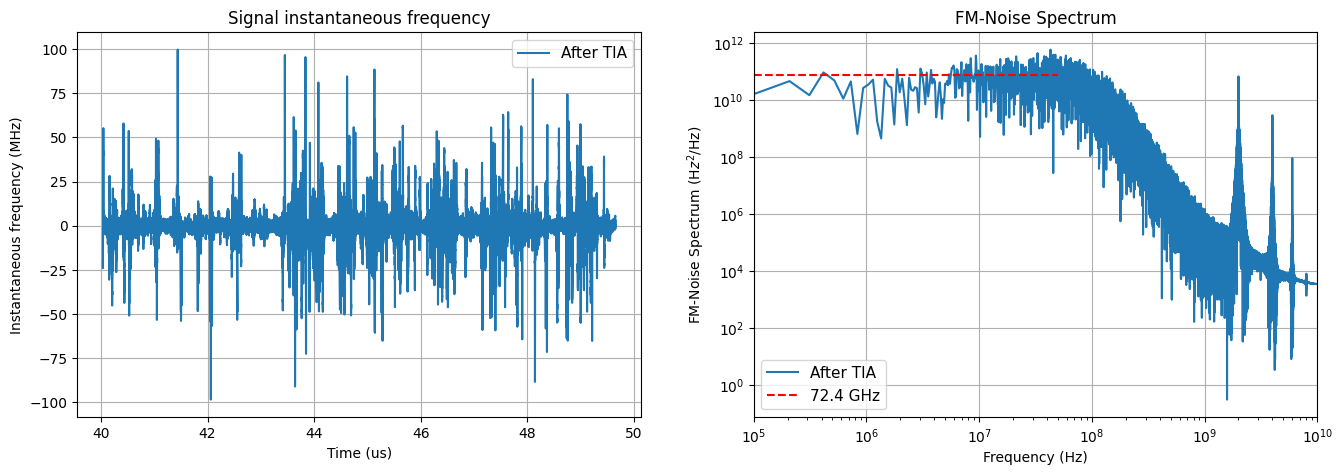

In [47]:
CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
instFreq = (np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)) / (2*np.pi*Ts) # Instantaneous frequency

print(f'Fs = {(1/Ts)*1e-9} GSamples/s')

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(16)

StTime = np.min(timeArray*1e6) # Starting time post delay

freq, spectrum = get_spectrum(instFreq[200:], Fs=Fs, Fc=0, xunits='hz', yunits='hz',sides='onesided')

ax[0].plot(timeArray[200:]*1e6,instFreq[200:]*1e-6, label='After TIA')
ax[0].set_xlabel('Time (us)')
# ax[0].set_xlim(StTime+10,StTime+11)
ax[0].set_ylabel('Instantaneous frequency (MHz)')
ax[0].set_title(f'Signal instantaneous frequency')
ax[0].grid()
ax[0].legend(fontsize=11)

cutLims = [1e5,5e7]
initFreq = int(cutLims[0]/freq[-1]*len(freq))
endFreq = int(cutLims[1]/freq[-1]*len(freq))
Measurefreq = freq[initFreq:endFreq]
Measurespectrum = spectrum[initFreq:endFreq]

ax[1].plot(freq,spectrum, label='After TIA')
ax[1].hlines(np.mean(Measurespectrum),xmin=cutLims[0], xmax=cutLims[1], color='red', linestyle='--', label=f'{np.round(np.mean(Measurespectrum)*1e-9,2)} GHz')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('FM-Noise Spectrum (H$z^2$/Hz)')
ax[1].set_xlim(1e5 , 1e10)
ax[1].set_title(f'FM-Noise Spectrum')
ax[1].grid()
ax[1].legend(fontsize=11)

## Phase-Error Variance

<IPython.core.display.Math object>

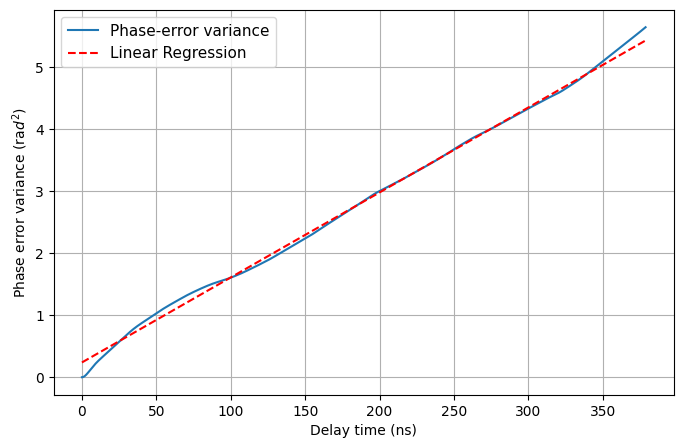

In [48]:
ShiftArray = np.linspace(0,8000,1200)

CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
varianceArray = np.zeros(len(ShiftArray))

for i in range(len(ShiftArray)):
    phaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),ShiftArray[i],cval=0)  # Instantaneous frequency
    varianceArray[i] = np.mean(phaseDiff[200+int(ShiftArray[i]):]**2)

polyArray = np.polyfit(ShiftArray[:900]*Ts,varianceArray[:900],1)

plt.figure(figsize=(8,5))
plt.plot(ShiftArray*Ts*1e9,varianceArray,label='Phase-error variance')
plt.plot(ShiftArray*Ts*1e9,polyArray[0]*ShiftArray*Ts+polyArray[1],'--',color='red',label='Linear Regression')
plt.ylabel('Phase error variance (ra$d^2$)')
plt.xlabel('Delay time (ns)')
plt.grid()
plt.legend(fontsize=11)

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(polyArray[0]*1e-6/(2*np.pi) , (polyArray[0]*1e-6/(2*np.pi))/2 )))